In [148]:
import os
import importlib.util
import math

import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt 

from alad_mod.alad import ALAD


In [157]:
#paths
result_path = '/home/oliverkn/pro/results/4_4/alad/5/'
data_file = '/home/oliverkn/pro/data/4_4/valid_supervised.npy'
config_file = result_path + 'python/config.py'
weights_file = result_path + 'model-100000'

# parameters
max_samples = 500_000

# loading config
spec = importlib.util.spec_from_file_location('config', config_file)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)


In [158]:
# data = np.load(data_file, allow_pickle=True).item()
# x, y = data['x'], data['y']
# 
# print('data shape:' + str(x.shape))
# 
# # shuffle and take subset
# if x.shape[0] > max_samples:
#     print('shuffle and taking subset')
#     x, y = sklearn.utils.shuffle(x, y)  # just in case if dataset is not shuffled before
#     x, y = x[:max_samples], y[:max_samples]
# 
# print('data shape:' + str(x.shape))
# 
# # only sm
# x = x[y == 0]
# 
# print('data shape:' + str(x.shape))

x = np.load(data_file, allow_pickle=True).item()['x']

print('data shape:' + str(x.shape))

# shuffle and take subset
if x.shape[0] > max_samples:
    print('shuffle and taking subset')
    x= sklearn.utils.shuffle(x)  # just in case if dataset is not shuffled before
    x = x[:max_samples]

print('data shape:' + str(x.shape))

data shape:(8932217, 23)
shuffle and taking subset
data shape:(500000, 23)


In [159]:
tf.reset_default_graph()
ad = ALAD(config, tf.Session())
ad.load(weights_file)

x_recon = ad.recon(x)

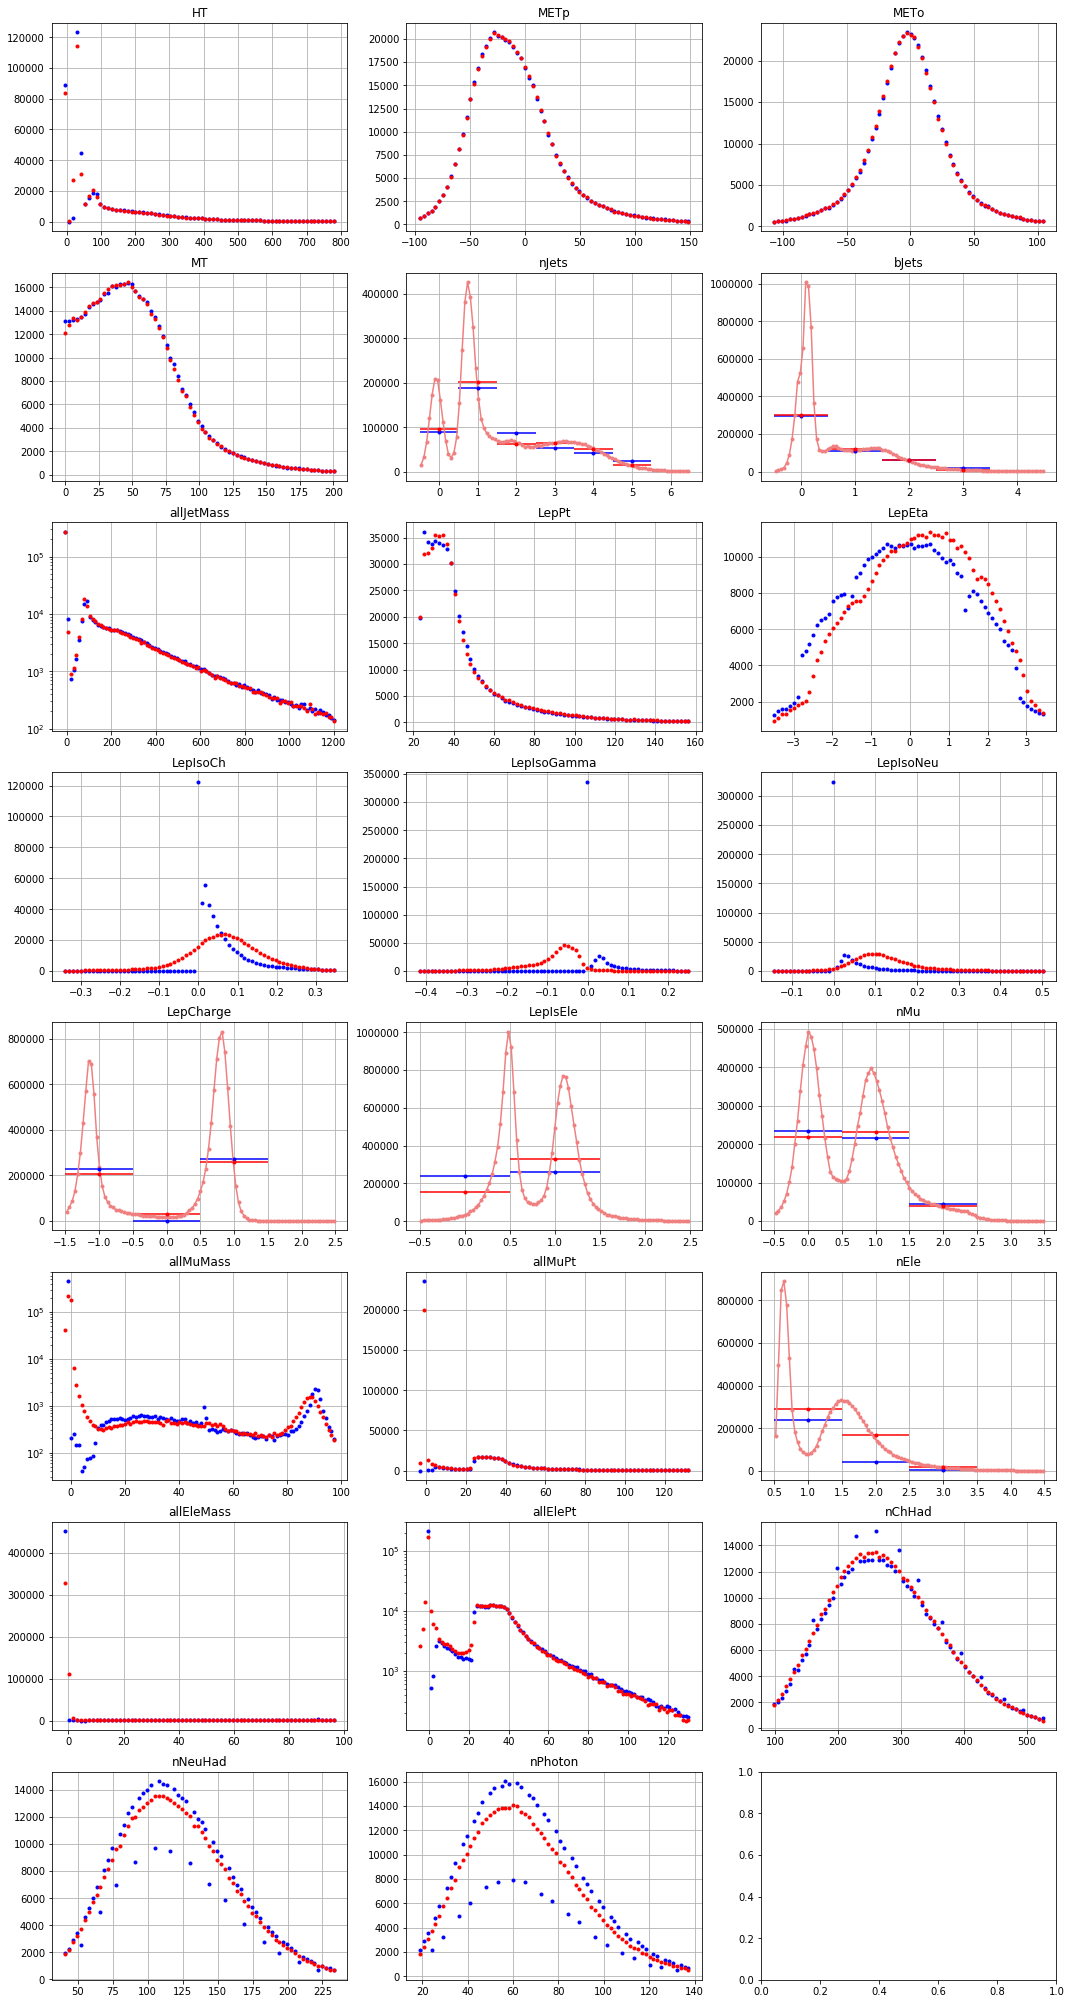

In [162]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

plot_mode ={}
plot_mode.update(dict.fromkeys(['nJets', 'bJets','LepCharge','LepIsEle', 'nMu','nEle'],'discrete'))
plot_mode.update(dict.fromkeys(['LepIso', 'allJetMass','allMuMass', 'allMuPt''allEleMass', 'allElePt'],'log'))

f, ax_arr = plt.subplots(int(math.ceil(len(hlf_features)/3.)),3 , figsize=(18,36))

for i, name in enumerate(hlf_features):
    x_i = x[:,i]
    x_recon_i = x_recon[:,i]
        
    ax = ax_arr[int(i/3), i%3]

    percentile = 1.
    histo_range = (np.minimum(np.percentile(x_recon_i, percentile),np.percentile(x_i, percentile)), 
                   np.maximum(np.percentile(x_recon_i, 100.-percentile),np.percentile(x_i, 100.-percentile)))
    
    
    ax.set_title(name)
    ax.grid()
    
    if name not in plot_mode.keys():
        n_bins = 70
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax.plot(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax.plot(bin_edges[:-1], bin_content,'r.')
        
    elif plot_mode[name] == 'discrete':
        histo_range = (math.floor(histo_range[0]), math.ceil(histo_range[1]))
        
        bins_con = np.linspace(histo_range[0], histo_range[1], 100) + 0.5
        bins_dis = np.arange(histo_range[0], histo_range[1]) + 0.5
        n_bins_dis = len(bins_dis)
        
        # plot recon with 100 bins
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_con)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.plot(bincenters, 100./n_bins_dis *bin_content, color='lightcoral', marker='.')
        
        # plot recon and original discrete
        bin_content, bin_edges = np.histogram(x_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.errorbar(bincenters, bin_content, xerr = 0.5, fmt='b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.errorbar(bincenters, bin_content, xerr = 0.5, fmt='r.')
        
    elif plot_mode[name] == 'log':
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax.semilogy(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax.semilogy(bin_edges[:-1], bin_content,'r.')
        
    else: raise Exception()
    
plt.show()

<ErrorbarContainer object of 3 artists>

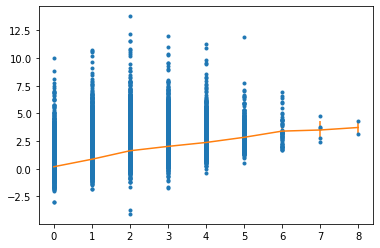

In [188]:
plt.plot(x[:,5],x_recon[:,5], '.')

#todo plot rms, and normalized hist2d
#plt.hist2d(x[:,5],x_recon[:,5],bins=100, range=[[0, 6], [0, 6]])
i = 5
x_i = x[:,i]
x_recon_i = x_recon[:,i]

bins = np.arange(0, 10)

from scipy.stats import binned_statistic

bin_means, bin_edges, binnumber = binned_statistic(x_i, x_recon_i, statistic='mean',bins=bins)

#plt.plot(bin_edges[:-1], bin_means)

bin_error, bin_edges, binnumber = binned_statistic(x_i, x_recon_i, statistic=np.std,bins=bins)
plt.errorbar(bin_edges[:-1], bin_means, yerr=bin_error)


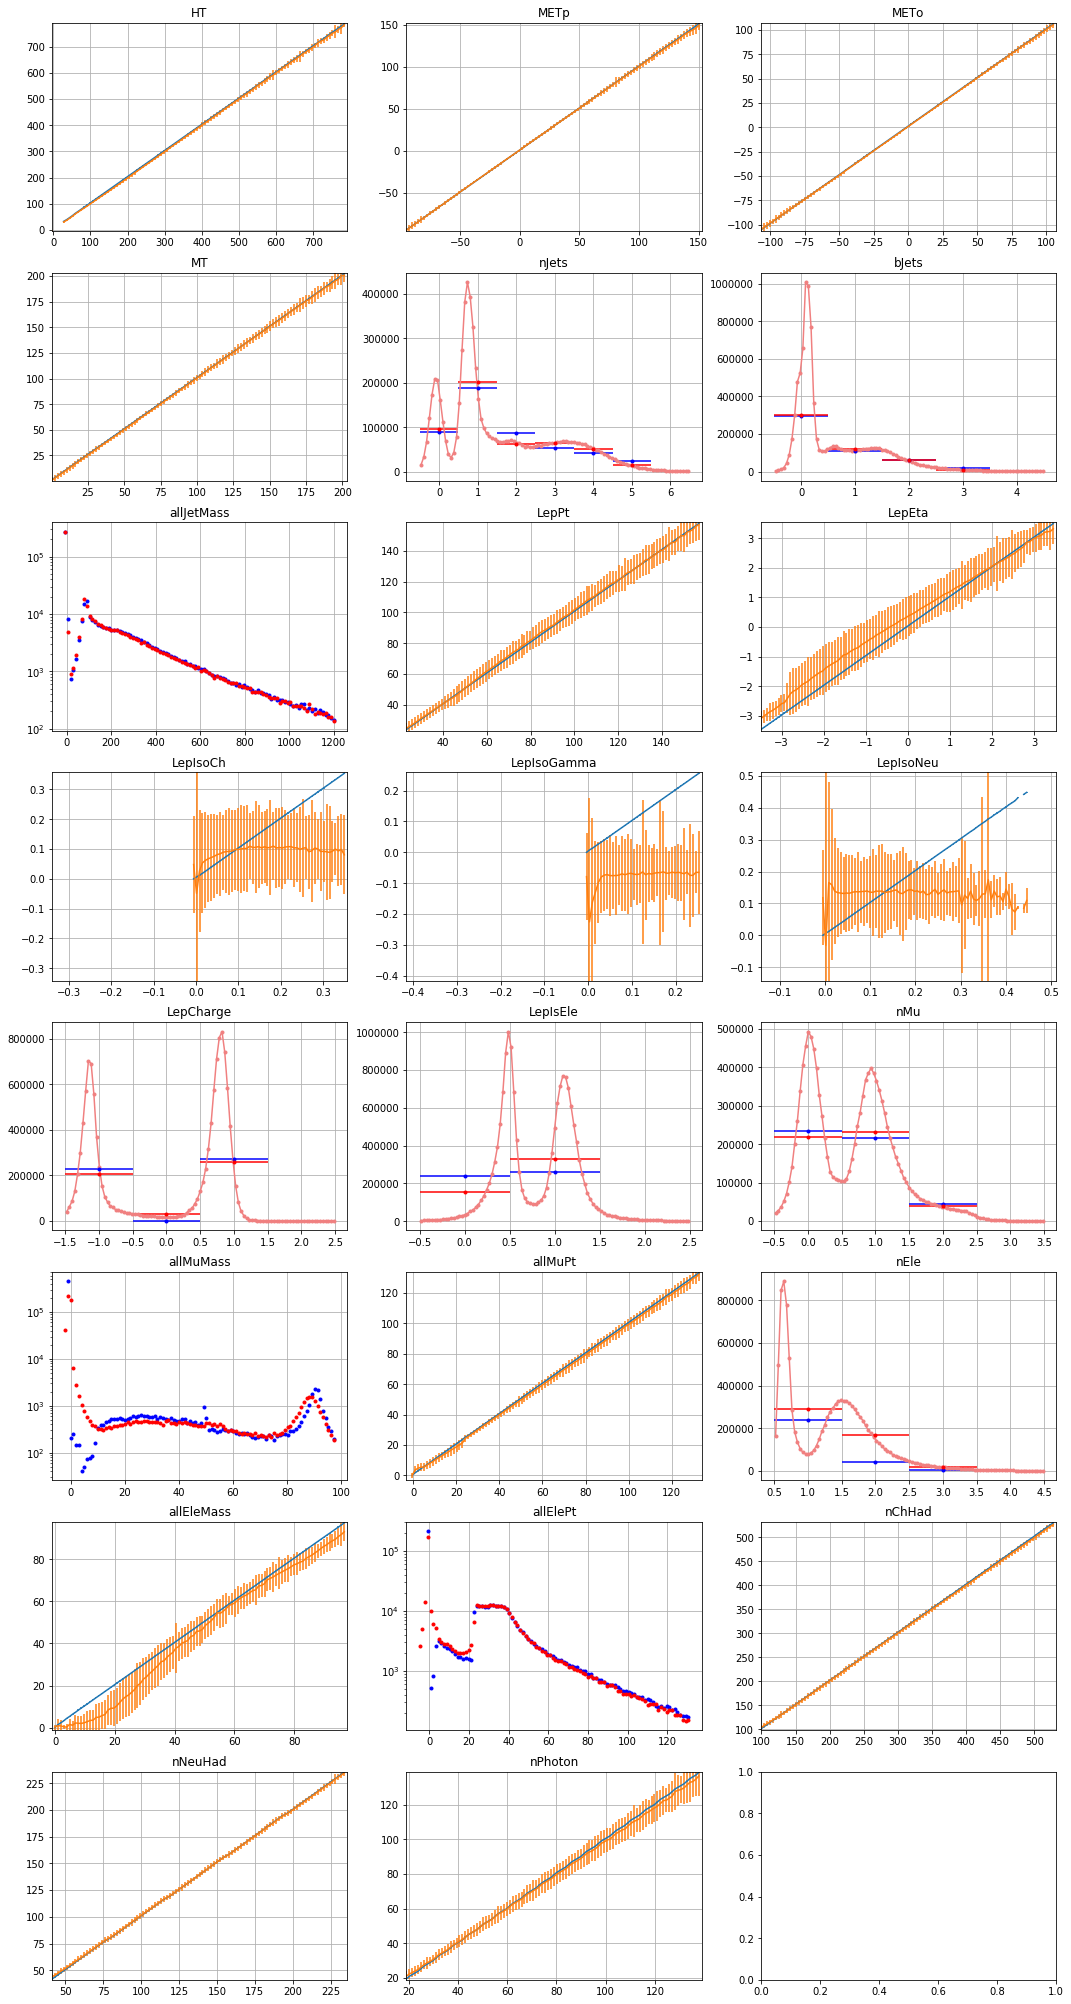

In [211]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

plot_mode ={}
plot_mode.update(dict.fromkeys(['nJets', 'bJets','LepCharge','LepIsEle', 'nMu','nEle'],'discrete'))
plot_mode.update(dict.fromkeys(['LepIso', 'allJetMass','allMuMass', 'allMuPt''allEleMass', 'allElePt'],'log'))

f, ax_arr = plt.subplots(int(math.ceil(len(hlf_features)/3.)),3 , figsize=(18,36))

for i, name in enumerate(hlf_features):
    x_i = x[:,i]
    x_recon_i = x_recon[:,i]
        
    ax = ax_arr[int(i/3), i%3]

    percentile = 1.
    histo_range = (np.minimum(np.percentile(x_recon_i, percentile),np.percentile(x_i, percentile)), 
                   np.maximum(np.percentile(x_recon_i, 100.-percentile),np.percentile(x_i, 100.-percentile)))
    
    
    ax.set_title(name)
    ax.grid()
    
    if name not in plot_mode.keys():
        n_bins = 100
        
        rms_fun = lambda x: np.sqrt(np.sum(x**2)/len(x))
        
        #std, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        #nrmsd_res, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=nrmsd, bins=n_bins,range=histo_range)
        
        #ax.plot(bin_edges[:-1], std)
        #ax.plot(bin_edges[:-1], nrmsd_res)
        
        mean_true, bin_edges, _ = binned_statistic(x_i, x_i, statistic='mean', bins=n_bins,range=histo_range)
        std_true, bin_edges, _ = binned_statistic(x_i, x_i, statistic=np.std, bins=n_bins,range=histo_range)
        mean, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic='mean', bins=n_bins,range=histo_range)
        rms, bin_edges, _ = binned_statistic(x_i, x_recon_i, statistic=np.std, bins=n_bins,range=histo_range)
        
        ax.errorbar(bin_edges[:-1], mean_true, yerr=std_true)
        ax.errorbar(bin_edges[:-1], mean, yerr=rms)
        ax.set(xlim=histo_range, ylim=histo_range)
        
    elif plot_mode[name] == 'discrete':
        histo_range = (math.floor(histo_range[0]), math.ceil(histo_range[1]))
        
        bins_con = np.linspace(histo_range[0], histo_range[1], 100) + 0.5
        bins_dis = np.arange(histo_range[0], histo_range[1]) + 0.5
        n_bins_dis = len(bins_dis)
        
        # plot recon with 100 bins
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_con)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.plot(bincenters, 100./n_bins_dis *bin_content, color='lightcoral', marker='.')
        
        # plot recon and original discrete
        bin_content, bin_edges = np.histogram(x_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.errorbar(bincenters, bin_content, xerr = 0.5, fmt='b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=bins_dis)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        ax.errorbar(bincenters, bin_content, xerr = 0.5, fmt='r.')
        
    elif plot_mode[name] == 'log':
        n_bins = 100
        
        bin_content, bin_edges = np.histogram(x_i, bins=n_bins, range=histo_range)
        ax.semilogy(bin_edges[:-1], bin_content,'b.')
        
        bin_content, bin_edges = np.histogram(x_recon_i, bins=n_bins, range=histo_range)
        ax.semilogy(bin_edges[:-1], bin_content,'r.')
        
    else: raise Exception()
    
plt.show()